In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import missingno as msno
from sklearn.base import TransformerMixin
from datetime import datetime
from scipy import stats
import math

In [282]:
## sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.feature_selection import RFE, RFECV
from sklearn.feature_selection import SelectKBest

from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, \
    RandomForestClassifier, ExtraTreesClassifier, VotingClassifier

from xgboost import XGBClassifier, XGBRegressor
from sklearn.decomposition import PCA

In [3]:
pd.options.display.max_rows = 200
pd.options.display.max_columns = 60

In [4]:
class FeatureExtractorToSeries(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x[self.column]

class FeatureExtractorToArray(FeatureExtractorToSeries):
    def transform(self, x, y=None):
        return x[self.column].values.reshape(-1,1)

In [133]:
def run_model(x_train, x_test, y_train, y_test, model):
    print(model)
    model.fit(x_train, y_train)
    print("Base model score: " + str(np.mean(y_test))[:6])
    print("Training set score: ", str(model.score(x_train, y_train))[:6])
    print("Test set score: ", str(model.score(x_test, y_test))[:6])
    predictions = model.predict(x_test)
    print("\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_0', 'predicted_1', 'predicted_2'],
                                                index=['is_0', 'is_1', 'is_2']))
    print("\nClassification Report:\n",classification_report(y_test, predictions))

def run_threshold_classifier(x_train, x_test, y_train, y_test, model, threshold_list):
    print(model)
    model.fit(x_train, y_train)
    print("Training set score: ", str(model.score(x_train, y_train))[:6])
    print("Test set score: ", str(model.score(x_test, y_test))[:6])
    probabilities = model.predict_proba(x_test)
    print(probabilities)
    thresholds = threshold_list
    for threshold in thresholds:
        print('\nWith tail probability threshold of %s:' % threshold)
        predictions = []
        for probability in probabilities:
            if probability[0] > threshold:
                predictions.append(0)
            elif probability[2] > threshold:
                predictions.append(2)
            else:
                predictions.append(1)
        print("\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, predictions), 
                                                  columns=['predicted_0', 'predicted_1', 'predicted_2'],
                                                    index=['is_0', 'is_1', 'is_2']))
        print("\nClassification Report:\n",classification_report(y_test, predictions))
        
    
def run_regression_model(x_train, x_test, y_train, y_test, model):
    model.fit(x_train, y_train)
    print(model)
    print("Training set r score: ", model.score(x_train, y_train))
    print("Test set r score: ", model.score(x_test, y_test))
    predictions = model.predict(x_test)
    print("Mean Absolute Error on Test Set:", mean_absolute_error(y_test, predictions))
    print("Mean Squared Error on Test Set:", mean_squared_error(y_test, predictions))
    plt.scatter(y_test, predictions)
    plt.ylabel('Predicted Score')
    plt.xlabel('Actual Score')
    plt.plot([0, 5], [0, 5])
    plt.show()
    plt.clf()
    



In [6]:
countries = ['United States',
       'Norway', 'Brazil', 'England', 'Sweden', 'Netherlands', 'Canada',
       'Germany', 'Australia', 'France', 'Italy', 'Belgium', 'Russia',
       'Mexico', 'Spain', 'New Zealand', 'Denmark', 'Finland', 'Scotland',
       'Czech Republic']

In [320]:
data = pd.read_csv('data/database/master.csv', index_col=0)

In [321]:
data['date_added'] = data['date_added'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').timestamp())
data['date_brewery_added'] = data['date_brewery_added'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').timestamp())

In [322]:
df, _ = train_test_split(data, train_size=0.8, random_state=5752)
print(df.shape, _.shape)
df = df.copy()

(564999, 141) (141250, 141)


In [323]:
df['rating_class'] = df['rating'].apply(rating_classes)
df['rating_class'].value_counts()

1    430579
0     69221
2     65199
Name: rating_class, dtype: int64

In [324]:
df['date_added'].describe()

count    5.649990e+05
mean     1.407559e+09
std      6.062374e+07
min      1.282367e+09
25%      1.365656e+09
50%      1.421129e+09
75%      1.458709e+09
max      1.492319e+09
Name: date_added, dtype: float64

In [10]:
us_df = df[df['United States'] == 1].copy()
us_df.drop(countries, axis=1, inplace=True)
print(us_df.shape)
lil_us = us_df.sample(n=50000)
lil_us.info()

(446214, 122)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 717259 to 635173
Columns: 122 entries, name to rating_class
dtypes: datetime64[ns](2), float64(82), int64(29), object(9)
memory usage: 46.9+ MB


In [11]:
lil_df = df.sample(n=50000)
lil_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 59877 to 239142
Columns: 142 entries, name to rating_class
dtypes: datetime64[ns](2), float64(102), int64(29), object(9)
memory usage: 54.6+ MB


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 706249 entries, 0 to 739257
Columns: 142 entries, name to rating_class
dtypes: datetime64[ns](2), float64(102), int64(29), object(9)
memory usage: 770.5+ MB


In [14]:
df[df['Home Brewery'] == 1]['rating'].describe()

count    1972.000000
mean        3.697992
std         0.289977
min         2.390000
25%         3.530000
50%         3.710000
75%         3.870000
max         4.600000
Name: rating, dtype: float64

In [274]:
df.columns[0:75]

Index(['name', 'brewery', 'style', 'rating', 'raters', 'abv', 'ibu',
       'total_checkins', 'unique_checkins', 'monthly_checkins', 'date_added',
       'description', 'beer_id', 'brewery_id', 'oop', 'has_description',
       'brewery_name', 'brewery_description', 'brewery_location',
       'brewery_num_beers', 'brewery_raters', 'brewery_rating',
       'date_brewery_added', 'monthly_brewery_checkins', 'subsidiary_id',
       'subsidiary_name', 'total_brewery_checkins', 'unique_brewery_checkins',
       'brewery_closed', 'is_subsidiary', 'official_account',
       'Bar / Restaurant / Store', 'Brew Pub', 'Cidery / Meadery',
       'Collaboration Brewery', 'Home Brewery', 'Macro Brewery',
       'Micro Brewery', 'Nano Brewery', 'United States', 'Norway', 'Brazil',
       'England', 'Sweden', 'Netherlands', 'Canada', 'Germany', 'Australia',
       'France', 'Italy', 'Belgium', 'Russia', 'Mexico', 'Spain',
       'New Zealand', 'Denmark', 'Finland', 'Scotland', 'Czech Republic', 'AK',
   

In [275]:
df.columns[75:]

Index(['IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MH', 'MI', 'MN', 'MO', 'MS',
       'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR',
       'PA', 'PR', 'PW', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI', 'VT',
       'WA', 'WI', 'WV', 'WY', 'brewery_has_description', 'in_smokes',
       'in_ryes', 'in_spiced', 'in_trad_german', 'in_trad_brit', 'in_thicks',
       'in_fall_winter', 'in_lager_lager', 'in_subpremiums', 'in_porters',
       'in_stouts', 'in_browns', 'in_yeasty_belgians', 'in_light_ales',
       'in_ambers', 'in_wheats', 'in_pilsners', 'in_sours', 'in_pale_ales',
       'in_ipas', 'in_ales', 'in_lagers', 'in_others', 'style_frequency',
       'in_strongs', 'rating_class'],
      dtype='object')

Consider stratifying on train/test and other cross val measures since target data is center-heavy

In [276]:
y = df['rating'].values
lil_y = lil_df['rating'].values
us_y = lil_us['rating'].values
# y = df['rating'].apply(math.log).values

In [64]:
stats.describe(y)

DescribeResult(nobs=706249, minmax=(1.01, 5.0), mean=3.6091241899103577, variance=0.12816889913518648, skewness=-0.7408002269928498, kurtosis=2.522328414543245)

In [62]:
df['rating'].describe()

count    706249.000000
mean          3.609124
std           0.358007
min           1.010000
25%           3.430000
50%           3.630000
75%           3.830000
max           5.000000
Name: rating, dtype: float64

In [67]:
num_under_3 = df[df['rating'] < 3.25].shape[0]
num_4_or_more = df[df['rating'] >= 4].shape[0]
total = df.shape[0]
print(num_under_3/total)
print(num_4_or_more/total)

0.12227557136364087
0.11540122534686775


(array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          4.90000000e+01,   1.10000000e+02,   3.11000000e+02,
          7.96000000e+02,   1.80800000e+03,   3.87400000e+03,
          8.21300000e+03,   1.95220000e+04,   5.16740000e+04,
          1.42718000e+05,   2.32342000e+05,   1.63330000e+05,
          6.11300000e+04,   1.68860000e+04,   3.24000000e+03,
          2.46000000e+02]),
 array([ 0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,  2.25,
         2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,  4.5 ,
         4.75,  5.  ]),
 <a list of 19 Patch objects>)

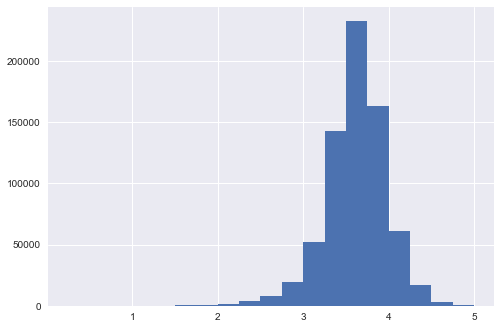

In [60]:
plt.hist(y, bins=np.arange(0.25, 5.25, 0.25))

(array([  5.00000000e+00,   8.00000000e+00,   8.00000000e+00,
          1.10000000e+01,   1.60000000e+01,   1.10000000e+01,
          1.80000000e+01,   2.60000000e+01,   2.70000000e+01,
          3.80000000e+01,   6.90000000e+01,   8.00000000e+01,
          7.90000000e+01,   1.15000000e+02,   1.80000000e+02,
          2.49000000e+02,   3.26000000e+02,   4.59000000e+02,
          5.33000000e+02,   8.16000000e+02,   1.16500000e+03,
          1.62000000e+03,   2.15200000e+03,   2.95700000e+03,
          4.19300000e+03,   6.26200000e+03,   1.10580000e+04,
          1.69210000e+04,   3.02370000e+04,   5.54860000e+04,
          8.64480000e+04,   1.37833000e+05,   1.28744000e+05,
          1.09593000e+05,   6.10140000e+04,   2.95750000e+04,
          1.23360000e+04,   4.47700000e+03,   1.01000000e+03,
          9.40000000e+01]),
 array([ 0.00995033,  0.04993752,  0.08992471,  0.1299119 ,  0.16989909,
         0.20988628,  0.24987347,  0.28986066,  0.32984785,  0.36983504,
         0.40982223,

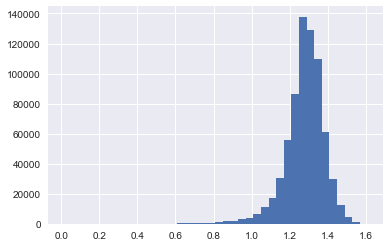

In [72]:
plt.hist(df['rating'].apply(math.log), bins=40)

In [326]:
style_features = ['in_smokes', 'in_ryes', 'in_spiced', 'in_trad_german', 'in_trad_brit', 'in_thicks',
       'in_fall_winter', 'in_lager_lager', 'in_subpremiums', 'in_porters',
       'in_stouts', 'in_browns', 'in_yeasty_belgians', 'in_light_ales',
       'in_ambers', 'in_wheats', 'in_pilsners', 'in_sours', 'in_pale_ales',
       'in_ipas', 'in_ales', 'in_lagers', 'in_others', 'in_strongs']

brewery_types = ['Brew Pub', 'Cidery / Meadery', 'Collaboration Brewery', 'Home Brewery',
       'Macro Brewery', 'Micro Brewery', 'Nano Brewery']

random_bools = ['brewery_closed', 'is_subsidiary', 'official_account', 'oop', 
                'brewery_has_description', 'has_description']

numeric_features = ['raters', 'brewery_raters', 'brewery_num_beers',
                    'total_checkins', 'unique_checkins', 'monthly_checkins', 
                    'total_brewery_checkins', 'unique_brewery_checkins', 
                    'monthly_brewery_checkins', 'style_frequency']

date_features = ['date_added', 'date_brewery_added']

country_features = ['United States',
       'Norway', 'Brazil', 'England', 'Sweden', 'Netherlands', 'Canada',
       'Germany', 'Australia', 'France', 'Italy', 'Belgium', 'Russia',
       'Mexico', 'Spain', 'New Zealand', 'Denmark', 'Finland', 'Scotland',
       'Czech Republic']

state_features = ["AK","AL","AR","AZ","CA","CO","CT","DC",
                "DE","FL","GA","GU","HI","IA","ID", "IL",
                "IN","KS","KY","LA","MA","MD","ME","MH",
                "MI","MN","MO","MS","MT","NC","ND","NE","NH",
                "NJ","NM","NV","NY", "OH","OK","OR","PA","PR",
                "PW","RI","SC","SD","TN","TX","UT","VA","VI",
                "VT","WA","WI","WV","WY"]

aas_yet_unused = ['abv', 'ibu', 'description', 'beer_id', 'brewery_id', 'brewery_name',
                  'brewery_description', 'brewery_location', 'brewery_rating', 
                  'subsidiary_id', 'subsidiary_name',]

# ('in_smokes', -0.0),
#  ('in_lager_lager', -0.0),
#  ('in_others', 0.0),
#  ('Brew Pub', 0.0),
#  ('brewery_raters', 0.0),
#  ('unique_checkins', 0.0),
#  ('unique_brewery_checkins', 0.0),
#  ('GU', 0.0),
#  ('HI', -0.0),
#  ('LA', 0.0),
#  ('MH', 0.0),
#  ('MS', -0.0),
#  ('MT', 0.0),
#  ('NE', -0.0),
#  ('NH', 0.0),
#  ('OK', -0.0),
#  ('OR', -0.0),
#  ('SD', -0.0),
#  ('UT', 0.0),
#  ('VI', 0.0),
#  ('WA', -0.0),
#  ('WV', -0.0),
#  ('WY', -0.0),
#  ('Russia', -0.0),
#  ('Mexico', -0.0),


features = style_features + brewery_types + random_bools + numeric_features + \
            state_features + country_features + date_features



# features_to_remove = ['in_smokes', 'in_lager_lager', 'in_others', 'Brew Pub', 'brewery_raters', 'unique_checkins',
#                      'unique_brewery_checkins']

# for feature in features_to_remove:
#     features.remove(feature)



print(len(features))
print(features)

df['rating_class'] = df['rating'].apply(rating_classes)

heads = df[df['rating_class'] == 2]
hearts = df[df['rating_class'] == 1].sample(80000)
tails = df[df['rating_class'] == 0]

heads_y = heads['rating'].values
heads_x = heads[features].values

hearts_y = hearts['rating'].values
hearts_x = hearts[features].values

tails_y = tails['rating'].values
tails_x = tails[features].values

# x = df[features].values
# lil_x = StandardScaler().fit_transform(lil_df[features].values)
# us_x = lil_us[features].values

# y = df['rating'].values
# lil_y = lil_df['rating'].values
# us_y = lil_us['rating'].values

# all style bools scores: .25 r .23 mae
# raters = .013 r .26 mae
# total_checkins = .015 r .26 mae
# date_added = .062 r .255 mae
# oop = .008 r .26 mae
# brewery_num_beers = 0.104 r, .25 mae, .11 mse
# all features, rfr, 100 trees = 0.53 r 0.17 mae 0.06 mse
print('all done!!')

125
['in_smokes', 'in_ryes', 'in_spiced', 'in_trad_german', 'in_trad_brit', 'in_thicks', 'in_fall_winter', 'in_lager_lager', 'in_subpremiums', 'in_porters', 'in_stouts', 'in_browns', 'in_yeasty_belgians', 'in_light_ales', 'in_ambers', 'in_wheats', 'in_pilsners', 'in_sours', 'in_pale_ales', 'in_ipas', 'in_ales', 'in_lagers', 'in_others', 'in_strongs', 'Brew Pub', 'Cidery / Meadery', 'Collaboration Brewery', 'Home Brewery', 'Macro Brewery', 'Micro Brewery', 'Nano Brewery', 'brewery_closed', 'is_subsidiary', 'official_account', 'oop', 'brewery_has_description', 'has_description', 'raters', 'brewery_raters', 'brewery_num_beers', 'total_checkins', 'unique_checkins', 'monthly_checkins', 'total_brewery_checkins', 'unique_brewery_checkins', 'monthly_brewery_checkins', 'style_frequency', 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MH', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 

In [177]:
pca = PCA(n_components=1)

In [182]:
sample = df.sample(100000).copy()
y = sample['rating'].values
x = sample[features].values
new_x = pca.fit_transform(x)

In [183]:
new_x.shape

(100000, 1)

In [184]:
pca.explained_variance_ratio_

array([ 0.99092426])

done splitting. running model...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Training set r score:  0.0141306764609
Test set r score:  0.0123389895785
Mean Absolute Error on Test Set: 0.261194392891
Mean Squared Error on Test Set: 0.12385626796


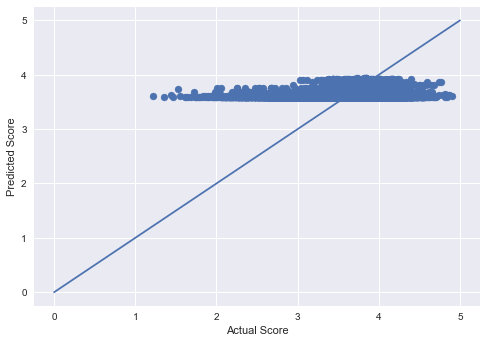

In [186]:
pca_lr = LinearRegression()
x_train, x_test, y_train, y_test = train_test_split(new_x, y)
print('done splitting. running model...')
run_regression_model(x_train, x_test, y_train, y_test, pca_lr)

It looks like guessing the average gives us around 0.24 mean average error. This serves as a baseline for further modeling, and also suggests that mean squared error might be a better metric

# High Val Regressor

In [187]:
x_train, x_test, y_train, y_test = train_test_split(heads_x, heads_y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(48899, 123) (16300, 123) (48899,) (16300,)


In [188]:
### Model types
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=18)
etr = ExtraTreesRegressor(n_estimators=100, n_jobs=-1)
hxgbr = XGBRegressor(max_depth=18, n_estimators=100)

models = [hxgbr]

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=18,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Training set r score:  0.912992829658
Test set r score:  0.432128376066
Mean Absolute Error on Test Set: 0.0832181531227
Mean Squared Error on Test Set: 0.0130213974066


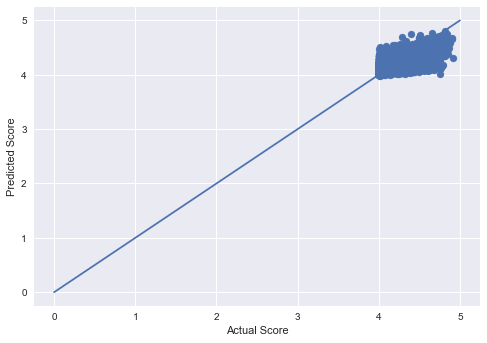

In [189]:
for model in models:
    run_regression_model(x_train, x_test, y_train, y_test, model)

In [193]:
high_model = hxgbr.fit(heads_x, heads_y)

# Mid Val Regressor

In [194]:
x_train, x_test, y_train, y_test = train_test_split(hearts_x, hearts_y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(60000, 123) (20000, 123) (60000,) (20000,)


In [197]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_depth=18)
etr = ExtraTreesRegressor(n_estimators=100, n_jobs=-1, max_depth=18)
mxgbr = XGBRegressor(max_depth=18, n_estimators=100)

models = [mxgbr]

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=18,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Training set r score:  0.85346764016
Test set r score:  0.3574457064
Mean Absolute Error on Test Set: 0.118286054115
Mean Squared Error on Test Set: 0.0229504638654


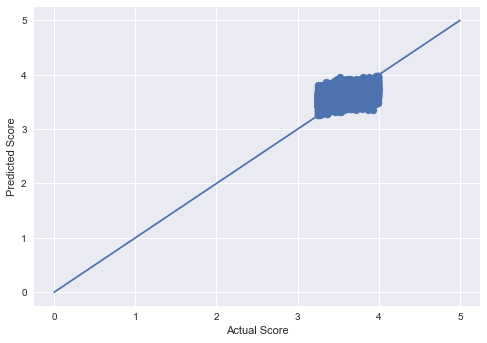

In [200]:
for model in models:
    run_regression_model(x_train, x_test, y_train, y_test, model)

In [201]:
mid_model = mxgbr.fit(hearts_x, hearts_y)

# Low Val Regressor

In [202]:
x_train, x_test, y_train, y_test = train_test_split(tails_x, tails_y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(51915, 123) (17306, 123) (51915,) (17306,)


In [205]:
rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)
etr = ExtraTreesRegressor(n_estimators=100, n_jobs=-1)
lxgbr = XGBRegressor(max_depth=18, n_estimators=100)

models = [lxgbr]

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=18,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Training set r score:  0.925326643526
Test set r score:  0.477412171861
Mean Absolute Error on Test Set: 0.141648021805
Mean Squared Error on Test Set: 0.0456952019581


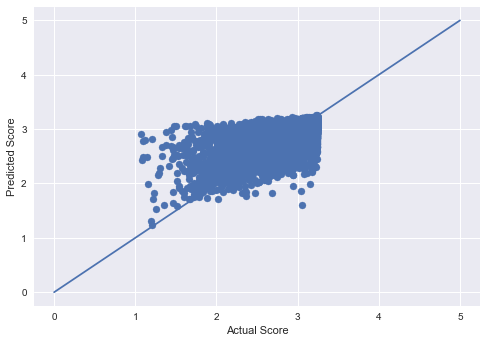

In [206]:
for model in models:
    run_regression_model(x_train, x_test, y_train, y_test, model)

In [207]:
low_model = lxgbr.fit(tails_x, tails_y)

In [62]:
lil_df.head()

,name,brewery,style,rating,raters,abv,ibu,total_checkins,unique_checkins,monthly_checkins,date_added,description,beer_id,brewery_id,oop,has_description,brewery_name,brewery_description,brewery_location,brewery_num_beers,brewery_raters,brewery_rating,date_brewery_added,monthly_brewery_checkins,subsidiary_id,subsidiary_name,total_brewery_checkins,unique_brewery_checkins,brewery_closed,is_subsidiary,...,WV,WY,brewery_has_description,in_smokes,in_ryes,in_spiced,in_trad_german,in_trad_brit,in_thicks,in_fall_winter,in_lager_lager,in_subpremiums,in_porters,in_stouts,in_browns,in_yeasty_belgians,in_light_ales,in_ambers,in_wheats,in_pilsners,in_sours,in_pale_ales,in_ipas,in_ales,in_lagers,in_others,style_frequency,in_strongs,rating_class,predicted_class
59877,Plead The 5th Imperial Stout (2010),Dark Horse Brewing Co.,Stout - American Imperial / Double,4.12,225.0,12.00,NaN,288.0,270.0,1.0,2011-12-31,It's big and full bodied with lots of roasted ...,115335,426,1,1,Dark Horse Brewing Co.,Some things in life are easily read and some t...,"Marshall, MI United States",486.0,706099.0,3.80,2010-11-06,14305.0,NaN,NaN,995116.0,238087.0,0.0,0.0,...,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,9235.0,0,2,2
680564,Rye IPA,Lengthwise Brewing Company,Rye IPA,3.91,120.0,7.00,NaN,162.0,138.0,26.0,2016-12-11,NaN,1860431,5102,0,0,Lengthwise Brewing Company,New location: Lengthwise Brewing 7700 District...,"Bakersfield, CA United States",93.0,14191.0,3.83,2010-12-11,362.0,NaN,NaN,20806.0,5017.0,0.0,0.0,...,0.0,0.0,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1109.0,0,1,1
245884,County Brown,Sebago Brewing Company,Brown Ale - American,3.50,138.0,5.20,NaN,173.0,158.0,0.0,2014-04-19,Specialty brown ale,654162,2624,0,1,Sebago Brewing Company,Sebago Brewing Company is a Maine-owned and op...,"Gorham, ME United States",156.0,68431.0,3.61,2010-11-09,1507.0,NaN,NaN,99850.0,34429.0,0.0,0.0,...,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,10985.0,0,1,1
495700,Barrel Series Barley Wine,Royal City Brewing,Barleywine - English,3.57,97.0,8.65,NaN,106.0,101.0,0.0,2015-12-31,NaN,1373820,80018,0,0,Royal City Brewing,Small Craft Brewery in the East End of Guelph....,"Guelph, ON Canada",244.0,22111.0,3.61,2013-09-07,975.0,NaN,NaN,29046.0,6414.0,0.0,0.0,...,0.0,0.0,1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2767.0,0,1,1
431437,Zwönitzer Stout,Brauerei Zwönitz,Stout - Other,3.12,566.0,5.10,NaN,635.0,604.0,27.0,2015-08-08,NaN,1192311,14759,0,0,Brauerei Zwönitz,NaN,Germany,21.0,3483.0,3.22,2011-08-08,222.0,NaN,NaN,4114.0,2528.0,0.0,0.0,...,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,14646.0,0,0,0


In [253]:
def get_importances(features, scores):
    importances = [pair for pair in zip(features, scores)]
    return sorted(importances, reverse=True, key=lambda x: x[1])

get_importances(features, rfr.feature_importances_)

[('in_ales', 0.11529155105097522),
 ('monthly_brewery_checkins', 0.11143308179485713),
 ('style_frequency', 0.066321815740868401),
 ('United States', 0.063509521312557077),
 ('unique_brewery_checkins', 0.061039160663275957),
 ('brewery_num_beers', 0.056888934817405146),
 ('raters', 0.041853136343407656),
 ('total_checkins', 0.039159050646855861),
 ('Macro Brewery', 0.03803672011331545),
 ('unique_checkins', 0.035579178596556543),
 ('total_brewery_checkins', 0.033653487439952959),
 ('brewery_raters', 0.033160149183953103),
 ('monthly_checkins', 0.029150943077552682),
 ('in_stouts', 0.028240492048502354),
 ('in_strongs', 0.020939366671555711),
 ('official_account', 0.015290411080483625),
 ('in_sours', 0.014061706406892105),
 ('has_description', 0.0096578888582058119),
 ('oop', 0.008283046307154613),
 ('in_ipas', 0.0072325016976013115),
 ('brewery_has_description', 0.0067782280789818435),
 ('in_trad_german', 0.006330734802085178),
 ('in_thicks', 0.0056791894537867975),
 ('in_subpremiums',

In [267]:
get_importances(features, la.coef_)

[('monthly_brewery_checkins', 0.11243299265449844),
 ('in_stouts', 0.077609215839120935),
 ('United States', 0.070165208976843946),
 ('in_ales', 0.05017068538040579),
 ('in_sours', 0.047716499330261133),
 ('in_strongs', 0.042439296394086369),
 ('in_ipas', 0.040642243397992786),
 ('official_account', 0.037184576972910492),
 ('in_thicks', 0.029833824953135211),
 ('in_trad_german', 0.027708458117405948),
 ('in_porters', 0.027086810081505527),
 ('Cidery / Meadery', 0.025394791076720557),
 ('brewery_has_description', 0.020679896141925284),
 ('Germany', 0.019753238953353073),
 ('in_yeasty_belgians', 0.019404123870760064),
 ('Canada', 0.018908654124946283),
 ('oop', 0.016936118661220665),
 ('Belgium', 0.016347188319727958),
 ('has_description', 0.015131980555213686),
 ('monthly_checkins', 0.013705324680802565),
 ('raters', 0.011190224474447064),
 ('Brazil', 0.0087362257575554596),
 ('New Zealand', 0.0086218979304993771),
 ('FL', 0.0080536344453889866),
 ('Italy', 0.0080115314171701618),
 ('Au

In [254]:
kbest = SelectKBest(k=len(features))
kbest.fit_transform(lil_x, lil_y)
get_importances(features, kbest.scores_)

//anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [70] are constant.
  UserWarning)
//anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


[('in_ales', 24.350138475842105),
 ('total_checkins', 23.13647845560299),
 ('in_lagers', 22.71789341113163),
 ('Macro Brewery', 22.248081681779119),
 ('official_account', 18.641794567579552),
 ('monthly_checkins', 16.568926098577847),
 ('in_subpremiums', 16.203875017454838),
 ('unique_checkins', 14.953268038268478),
 ('in_lager_lager', 14.073630253231157),
 ('raters', 13.86097328543797),
 ('in_stouts', 13.161728013373798),
 ('brewery_has_description', 8.806012400208342),
 ('in_strongs', 8.4094081680411001),
 ('is_subsidiary', 7.5899254809162882),
 ('in_pilsners', 7.4293281109266411),
 ('monthly_brewery_checkins', 6.829013598590234),
 ('in_ipas', 6.8087527911286552),
 ('unique_brewery_checkins', 5.4479576493797337),
 ('total_brewery_checkins', 5.377163143643406),
 ('in_sours', 5.29744427689125),
 ('brewery_raters', 5.2741962082873135),
 ('style_frequency', 4.7351718758234043),
 ('in_others', 4.5723933329288169),
 ('Micro Brewery', 4.5288626789498974),
 ('oop', 4.4830675630404322),
 ('in

In [203]:
rfr2 = RandomForestRegressor(n_jobs=-1)
selector = RFE(rfr2, 1, step=1, verbose=10)
selector.fit(lil_x, lil_y)
importances = [pair for pair in zip(features, selector.ranking_)]
sorted(importances, reverse=False, key=lambda x: x[1])

Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 features.
Fitting estimator with 56 features.
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 fe

[('monthly_brewery_checkins', 1),
 ('style_frequency', 2),
 ('brewery_num_beers', 3),
 ('total_checkins', 4),
 ('unique_brewery_checkins', 5),
 ('in_ales', 6),
 ('United States', 7),
 ('brewery_raters', 8),
 ('raters', 9),
 ('total_brewery_checkins', 10),
 ('unique_checkins', 11),
 ('monthly_checkins', 12),
 ('Macro Brewery', 13),
 ('in_stouts', 14),
 ('official_account', 15),
 ('in_ipas', 16),
 ('in_sours', 17),
 ('in_lagers', 18),
 ('oop', 19),
 ('Micro Brewery', 20),
 ('in_subpremiums', 21),
 ('in_yeasty_belgians', 22),
 ('in_porters', 23),
 ('in_thicks', 24),
 ('in_trad_german', 25),
 ('Cidery / Meadery', 26),
 ('in_light_ales', 27),
 ('Sweden', 28),
 ('Germany', 29),
 ('in_pale_ales', 30),
 ('Brew Pub', 31),
 ('is_subsidiary', 32),
 ('in_others', 33),
 ('in_wheats', 34),
 ('Canada', 35),
 ('in_trad_brit', 36),
 ('Finland', 37),
 ('England', 38),
 ('Nano Brewery', 39),
 ('in_ambers', 40),
 ('Brazil', 41),
 ('Russia', 42),
 ('Denmark', 43),
 ('in_browns', 44),
 ('France', 45),
 ('Ne

# Classification Work

In [327]:
equal_classes = pd.concat([heads, hearts, tails])

In [328]:
lil_df = equal_classes.sample(10000)

In [329]:
y = lil_df['rating_class'].values
x = lil_df[features]

In [330]:
x_train, x_test, y_train, y_test = train_test_split(x, y)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(7500, 125) (2500, 125) (7500,) (2500,)


In [331]:
test_rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1)
run_regression_model(x_train, x_test, y_train, y_test, test_rfr)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Training set r score:  0.938191802594
Test set r score:  0.533081861389
Mean Absolute Error on Test Set: 0.413928
Mean Squared Error on Test Set: 0.29693984


KeyboardInterrupt: 

In [310]:
rf = RandomForestClassifier(n_estimators=100, max_depth=18)
et = ExtraTreesClassifier(n_estimators=100, max_depth=18)  ### doing the best out of the box!!!!
gb = GradientBoostingClassifier()
xgb = XGBClassifier(n_estimators=100, silent=False, max_depth=20, reg_lambda=50, reg_alpha=.01)

### ideal probability threshold for extra trees model is 0.2 --> need to optimize for final model!!!

vc = VotingClassifier([('rf', rf), ('et', et), ('gb', gb)], n_jobs=-1)
vc_soft = VotingClassifier([('rf', rf), ('et', et), ('gb', gb)], voting='soft', n_jobs=-1)


class_models = [vc, vc_soft]

threshold_list = [.5]

In [333]:
for model in class_models:
    run_model(x_train, x_test, y_train, y_test, model)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_es...=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))],
         n_jobs=-1, voting='hard', weights=None)
Base model score: 0.9548
Training set score:  0.9209
Test set score:  0.6988

Confusion Matrix:
       predicted_0  predicted_1  predicted_2
is_0          632          186           36
is_1          160          576          169
is_2           33          169          539

Classification Report:
              precision    recall  f1-score   support

          0       0.77      0.74      0.75       854
          1       0.62      0.64      0.63       905
          2       0.72      0.73      0.73       741

avg / total      

In [332]:
for model in class_models:
    run_threshold_classifier(x_train, x_test, y_train, y_test, model, threshold_list)

VotingClassifier(estimators=[('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=18, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_es...=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))],
         n_jobs=-1, voting='hard', weights=None)
Training set score:  0.9209
Test set score:  0.6988


AttributeError: predict_proba is not available when voting='hard'

In [153]:
params = {
    'max_depth':[18, 22, None]
}

grid = GridSearchCV(rf, params, verbose=10)
grid.fit(x, y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] max_depth=18 ....................................................
[CV] ..................... max_depth=18, score=0.808195, total=   6.9s
[CV] max_depth=18 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.7s remaining:    0.0s


[CV] ..................... max_depth=18, score=0.813273, total=   6.7s
[CV] max_depth=18 ....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.2s remaining:    0.0s


[CV] ..................... max_depth=18, score=0.806312, total=   6.4s
[CV] max_depth=22 ....................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   22.5s remaining:    0.0s


[CV] ..................... max_depth=22, score=0.811615, total=   7.4s
[CV] max_depth=22 ....................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   30.7s remaining:    0.0s


[CV] ..................... max_depth=22, score=0.818013, total=   7.6s
[CV] max_depth=22 ....................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   39.3s remaining:    0.0s


[CV] ..................... max_depth=22, score=0.808892, total=   7.6s
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   47.8s remaining:    0.0s


[CV] ................... max_depth=None, score=0.812455, total=   8.8s
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   57.7s remaining:    0.0s


[CV] ................... max_depth=None, score=0.819093, total=   9.6s
[CV] max_depth=None ..................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.1min remaining:    0.0s


[CV] ................... max_depth=None, score=0.810692, total=  10.1s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [18, 22, None]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring=None, verbose=10)

Pipeline--> 
- fed a dataframe
- piped into classifier
- classes attached to new column
- dataframe split in 3 based on predicted class
- each slice fed into specific regression model
- predictions attached in new column
- dataframes concatenated
- predictions vs actuals scored


r^2 on Test Set: 0.724301547088
Mean Absolute Error on Test Set: 0.121300068571
Mean Squared Error on Test Set: 0.0354353125398


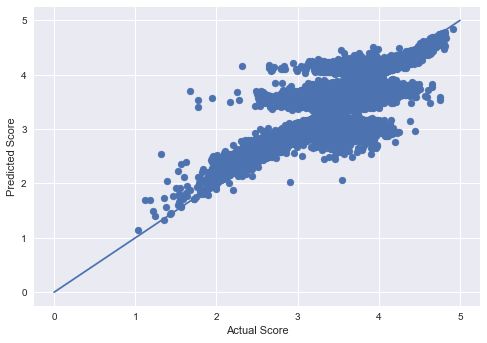

In [86]:
frames = [lil_highs, lil_meds, lil_lows]
final_frame = pd.concat(frames)
actuals = final_frame['rating']
predictions = final_frame['predicted_rating']
print("r^2 on Test Set:", r2_score(actuals, predictions))
print("Mean Absolute Error on Test Set:", mean_absolute_error(actuals, predictions))
print("Mean Squared Error on Test Set:", mean_squared_error(actuals, predictions))
plt.scatter(actuals, predictions)
plt.ylabel('Predicted Score')
plt.xlabel('Actual Score')
plt.plot([0, 5], [0, 5])
plt.show()
plt.clf()

# Pickling

In [110]:
from sklearn.externals import joblib

In [334]:
dataframe = lil_df
class_model = vc_soft
low_model = low_model
mid_model = mid_model
high_model = high_model

stratified_regressor = test_rfr

joblib.dump(class_model, 'data/pickle_jar/classifier.pkl')
joblib.dump(low_model, 'data/pickle_jar/low_model.pkl')
joblib.dump(mid_model, 'data/pickle_jar/mid_model.pkl')
joblib.dump(high_model, 'data/pickle_jar/high_model.pkl')
joblib.dump(stratified_regressor, 'data/pickle_jar/stratified_regressor.pkl')

['data/pickle_jar/stratified_regressor.pkl']